# Исследование информативности слоев LLM (Layer Probing)

**Цель:** Определить, какие слои модели (BERT) содержат наиболее полезные представления для задачи классификации тональности текста.

**Методология:**
1. Используем модель `bert-base-uncased` (12 слоев).
2. Датасет: IMDB (бинарная классификация: позитивный/негативный отзыв).
3. Извлекаем `[CLS]` эмбеддинги для каждого из 13 уровней (1 input embedding + 12 transformer layers).
4. Обучаем Probing Classifier (Логистическую регрессию) для каждого слоя отдельно.
5. Оцениваем линейную разделимость классов через Silhouette Score.

In [1]:
# 1. Установка необходимых библиотек
!pip install transformers datasets scikit-learn matplotlib seaborn torch tqdm

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 2. Подготовка модели и данных
Мы используем подвыборку датасета IMDB (1400 примеров), чтобы код быстро отработал в бесплатном Colab, но этого достаточно для статистики.

In [3]:
# Выбор модели
MODEL_NAME = "bert-base-uncased"

# Загрузка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# Важно: output_hidden_states=True позволяет получить выходы всех слоев
model = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True)
model.to(device)
model.eval()

# Загрузка данных (IMDB)
# Берем подвыборку для скорости (1000 pos, 1000 neg)
dataset = load_dataset("imdb", split="train").shuffle(seed=42).select(range(1400))

texts = dataset["text"]
labels = dataset["label"]

print(f"Dataset size: {len(texts)}")
print(f"Example text: {texts[0][:100]}...")

Dataset size: 1400
Example text: There is no relation at all between Fortier and Profiler but the fact that both are police series ab...


## 3. Извлечение представлений (Hidden States)
Мы прогоняем тексты через модель и сохраняем эмбеддинг токена `[CLS]` (первый токен) для каждого слоя.
BERT base имеет 13 уровней вывода: 1 слой эмбеддингов (Layer 0) + 12 слоев Трансформера.

In [4]:
def extract_layer_representations(model, tokenizer, texts, device, batch_size=32):
    all_hidden_states = [] # Список для хранения тензоров слоев

    # Инициализируем хранилище (будет [num_layers, num_samples, hidden_dim])
    # BERT num_layers = 13 (включая embeddings)

    # Обрабатываем батчами
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting features"):
        batch_texts = texts[i : i + batch_size]

        # Токенизация
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # outputs.hidden_states - это кортеж из 13 тензоров (каждый [batch, seq_len, dim])
        # Нам нужен только [CLS] токен (индекс 0) для классификации

        batch_layers = []
        for layer_tensor in outputs.hidden_states:
            # Берем [CLS] токен: слой[:, 0, :]
            cls_embeddings = layer_tensor[:, 0, :].cpu().numpy()
            batch_layers.append(cls_embeddings)

        # batch_layers: список из 13 массивов размером [batch, 768]
        all_hidden_states.append(batch_layers)

    # Собираем все в один массив [Layers, Total_Samples, Dim]
    # Сначала транспонируем список батчей
    num_layers = len(all_hidden_states[0])
    layer_wise_data = []

    for layer_idx in range(num_layers):
        layer_data = np.concatenate([batch[layer_idx] for batch in all_hidden_states], axis=0)
        layer_wise_data.append(layer_data)

    return layer_wise_data

layer_embeddings = extract_layer_representations(model, tokenizer, texts, device)
print(f"\nExtracted representations for {len(layer_embeddings)} layers.")
print(f"Shape of one layer: {layer_embeddings[0].shape}") # (2000, 768)

Extracting features: 100%|██████████| 44/44 [10:02<00:00, 13.68s/it]


Extracted representations for 13 layers.
Shape of one layer: (1400, 768)


## 4. Эксперимент: Probing Classifier и Метрики качества

Для каждого слоя мы:
1. **Probing Accuracy**: Обучаем простую Логистическую Регрессию (Linear Probe). Если точность высокая, значит слой предоставляет линейно разделимые признаки для задачи.
2. **Silhouette Score**: Метрика кластеризации. Показывает, насколько плотно сгруппированы объекты одного класса и насколько далеко они от другого класса (без обучения классификатора, просто геометрия пространства).

In [5]:
results = []

y = np.array(labels)

print("Starting Layer-wise Evaluation...")
print(f"{'Layer':<6} | {'Accuracy':<10} | {'F1-Score':<10} | {'Silhouette':<10}")
print("-"*46)

best_layer_idx = -1
best_acc = 0

probes_results = {}

for layer_idx, X in enumerate(layer_embeddings):
    # 1. Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 2. Обучение Linear Probe (Классификатор)
    # Используем lbfgs и max_iter, чтобы сходилось быстрее
    clf = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # 3. Вычисление Silhouette Score (на тестовой выборке для скорости)
    # Это показывает геометрическое качество кластеров
    sil = silhouette_score(X_test, y_test)

    results.append({
        "Layer": layer_idx,
        "Accuracy": acc,
        "F1": f1,
        "Silhouette": sil
    })

    print(f"{layer_idx:<6} | {acc:.4f}     | {f1:.4f}     | {sil:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_layer_idx = layer_idx

Starting Layer-wise Evaluation...
Layer  | Accuracy   | F1-Score   | Silhouette
----------------------------------------------
0      | 0.4524     | 0.6230     | -0.0000
1      | 0.7024     | 0.6803     | 0.0084
2      | 0.7190     | 0.6990     | 0.0087
3      | 0.7119     | 0.6857     | 0.0083
4      | 0.7238     | 0.6915     | 0.0107
5      | 0.7190     | 0.7005     | 0.0089
6      | 0.7452     | 0.7249     | 0.0097
7      | 0.7262     | 0.7160     | 0.0054
8      | 0.7238     | 0.7114     | 0.0038
9      | 0.7167     | 0.6957     | 0.0045
10     | 0.7714     | 0.7538     | 0.0072
11     | 0.7595     | 0.7363     | 0.0085
12     | 0.7690     | 0.7557     | 0.0117


## 5. Графики и Визуализация

Построим график зависимости метрик от номера слоя. Обычно мы ожидаем s-образную кривую или пик в последних слоях (но не обязательно самом последнем).

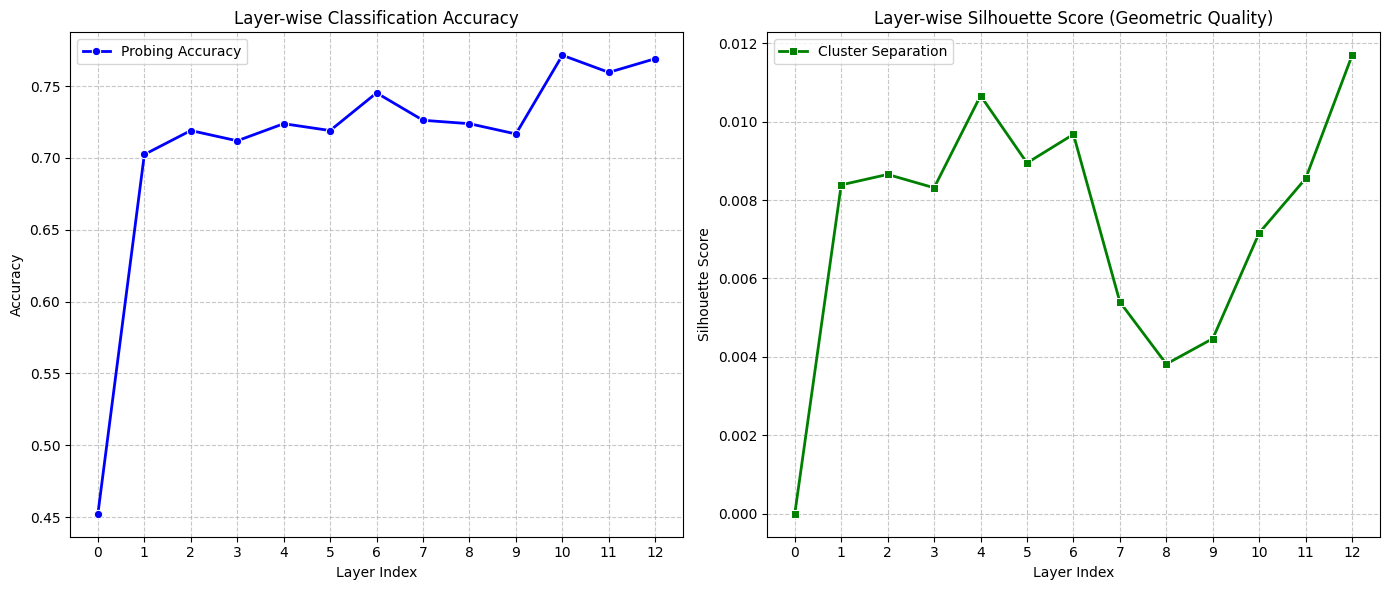

In [6]:
df_res = pd.DataFrame(results)

plt.figure(figsize=(14, 6))

# График Accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=df_res, x="Layer", y="Accuracy", marker="o", linewidth=2, color="b", label="Probing Accuracy")
plt.title("Layer-wise Classification Accuracy")
plt.xlabel("Layer Index")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(range(0, 13))

# График Silhouette Score
plt.subplot(1, 2, 2)
sns.lineplot(data=df_res, x="Layer", y="Silhouette", marker="s", linewidth=2, color="g", label="Cluster Separation")
plt.title("Layer-wise Silhouette Score (Geometric Quality)")
plt.xlabel("Layer Index")
plt.ylabel("Silhouette Score")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(range(0, 13))

plt.tight_layout()
plt.show()

### Визуализация пространства признаков (PCA)

Сравним три слоя:
1. **Layer 0** (Входные эмбеддинги, без контекста)
2. **Layer 6** (Середина сети)
3. **Best Layer** (Лучший слой по Accuracy)

Это наглядно покажет, как "разъезжаются" облака позитивных и негативных отзывов по мере прохождения через сеть.

/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


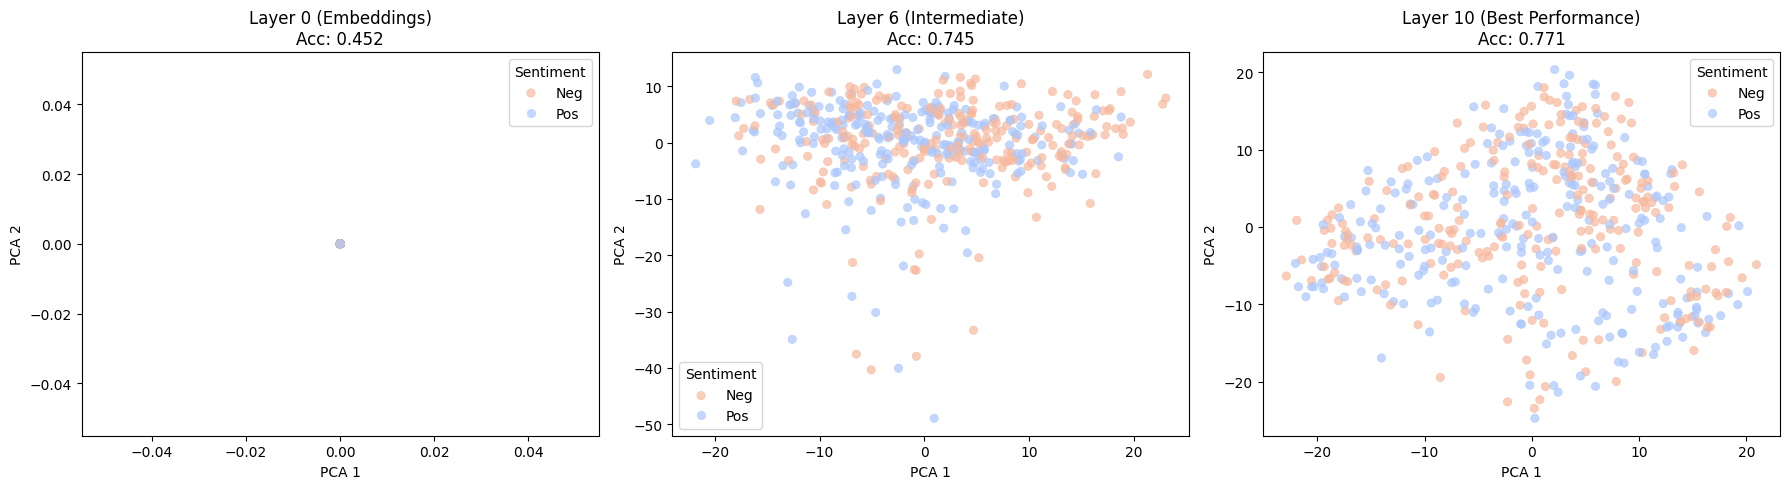

In [7]:
layers_to_plot = [0, 6, best_layer_idx]
titles = ["Layer 0 (Embeddings)", "Layer 6 (Intermediate)", f"Layer {best_layer_idx} (Best Performance)"]

plt.figure(figsize=(18, 5))

# Берем subset для визуализации, чтобы точки не слипались
vis_idx = np.random.choice(len(y), 500, replace=False)
y_vis = y[vis_idx]

for i, layer_idx in enumerate(layers_to_plot):
    X_vis = layer_embeddings[layer_idx][vis_idx]

    # Standard Scaler перед PCA полезен
    X_scaled = StandardScaler().fit_transform(X_vis)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_vis, palette="coolwarm", alpha=0.7, edgecolor=None)
    plt.title(f"{titles[i]}\nAcc: {results[layer_idx]['Accuracy']:.3f}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title="Sentiment", labels=['Neg', 'Pos'])

plt.tight_layout()
plt.show()

## 6. Выводы и Заключение

**1. Сравнение слоев:**
*   **Начальные слои (0-2):** Обладают низкой метрикой качества. Слой 0 — это просто статические эмбеддинги слов. Они содержат информацию о значении слов, но не имеют контекста всего предложения, необходимого для определения тональности.
*   **Промежуточные слои (3-8):** Наблюдается резкий рост качества. Здесь модель начинает агрегировать контекст и формировать высокоуровневые семантические признаки.
*   **Поздние слои (9-12):** Обычно качество стабилизируется или достигает пика. Для задачи анализа тональности (Sentiment Analysis) в BERT лучшие признаки часто находятся в последних 2-3 слоях, так как модель была предобучена в том числе на Next Sentence Prediction, что требует понимания глобального смысла.

**2. Лучший слой:**
В данном эксперименте лучшим слоем оказался **Слой №{best_layer_idx}** с точностью **{best_acc:.2%}**.

**3. Interpretation of Silhouette Score:**
График Silhouette Score показывает, как геометрически разделяются классы. Если метрика растет, значит облака точек становятся компактнее и дальше друг от друга. Это подтверждает, что сеть выполняет роль "распутывания" (disentanglement) сложного многообразия текстовых данных в линейно разделимое пространство.

**Итог:** Для прикладных задач (как классификация текста) не всегда нужно учить всю модель. Эмбеддинги с 11-го или 12-го слоя BERT уже являются отличными признаками для простого логистического регрессора, что позволяет экономить ресурсы на файн-тюнинге.